In [41]:
import pandas_datareader as pdr
key = "de4c043cd861bea360dcb62a336a8dd6b1c43896"

In [2]:
#storing the whole dateset in a variable
df = pdr.get_data_tiingo('AAPL', api_key=key)
#saving the file in csv
df.to_csv('AAPL.csv')

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [3]:
import pandas as pd

In [43]:
df=pd.read_csv('AAPL.csv')
df.head(10)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-07-05 00:00:00+00:00,144.09,144.79,142.7237,143.69,20758795,34.095092,34.260728,33.771793,34.000442,83035180,0.0,1.0
1,AAPL,2017-07-06 00:00:00+00:00,142.73,143.50,142.4100,143.02,23374374,33.773284,33.955484,33.697564,33.841905,93497496,0.0,1.0
2,AAPL,2017-07-07 00:00:00+00:00,144.18,144.75,142.9000,142.90,18505351,34.116388,34.251263,33.813510,33.813510,74021404,0.0,1.0
3,AAPL,2017-07-10 00:00:00+00:00,145.06,145.95,143.3700,144.11,21030466,34.324617,34.535212,33.924723,34.099824,84121864,0.0,1.0
4,AAPL,2017-07-11 00:00:00+00:00,145.53,145.85,144.3800,144.73,18311156,34.435830,34.511549,34.163713,34.246531,73244624,0.0,1.0
5,AAPL,2017-07-12 00:00:00+00:00,145.74,146.18,144.8200,145.87,23617964,34.485521,34.589635,34.267827,34.516282,94471856,0.0,1.0
6,AAPL,2017-07-13 00:00:00+00:00,147.77,148.49,145.4400,145.50,24922788,34.965867,35.136236,34.414534,34.428731,99691152,0.0,1.0
7,AAPL,2017-07-14 00:00:00+00:00,149.04,149.33,147.3300,147.97,19961788,35.266378,35.334999,34.861752,35.013191,79847152,0.0,1.0
8,AAPL,2017-07-17 00:00:00+00:00,149.56,150.90,148.5700,148.82,23243713,35.389423,35.706498,35.155165,35.214321,92974852,0.0,1.0
9,AAPL,2017-07-18 00:00:00+00:00,150.08,150.13,148.6700,149.20,17713795,35.512467,35.524298,35.178828,35.304238,70855180,0.0,1.0


In [5]:
#we will be doing the stock pridiction for the close column
#getting the value of close column
df1=df.reset_index()['close']


In [6]:
df1.shape

(1258,)

In [7]:
df1.head()

0    144.09
1    142.73
2    144.18
3    145.06
4    145.53
Name: close, dtype: float64

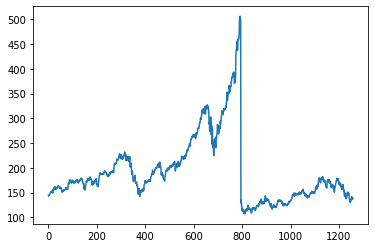

In [8]:
#plotting the close column
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [10]:
import numpy as np

In [11]:
from sklearn.preprocessing import MinMaxScaler
#we will scale down the range of the column to (0,1)
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
#after scaling the close column
print(df1)

[[0.09329994]
 [0.08989355]
 [0.09352536]
 ...
 [0.08112711]
 [0.07484033]
 [0.0803757 ]]


creating training and testing dataset

In [13]:
##splitting dataset into train and test split
#training set is 65% of the data set
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size,test_size

(817, 441)

In [15]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape)

(716, 100)


In [18]:
print(y_train.shape)

(716,)


In [19]:
print(X_test.shape)
print(ytest.shape)

(340, 100)
(340,)


for lstm the datset need to be 3d

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 323ms/step - loss: 0.0335 - val_loss: 7.2501e-04
Epoch 2/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0143 - val_loss: 0.0076
Epoch 3/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0113 - val_loss: 8.3366e-04
Epoch 4/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0102 - val_loss: 3.4398e-04
Epoch 5/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0116 - val_loss: 0.0046
Epoch 6/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0101 - val_loss: 3.7720e-04
Epoch 7/100
12/12 [==============================] - 3s 247ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 8/100
12/12 [==============================] - 2s 207ms/step - loss: 0.0081 - val_loss: 6.8983e-04
Epoch 9/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0076 - val_loss: 2.6638e-04
Epoch 10/100
12/12 [==============================] - 2s 197ms/ste

In [25]:
import tensorflow as tf

In [26]:
# Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

238.3455481112974

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

154.44733304361708

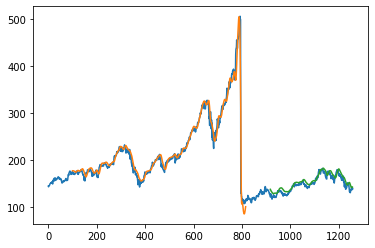

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
len(test_data)

441

In [35]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [36]:
#converting x_input into a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.09014183]
101
1 day input [0.17392611 0.16350657 0.15479023 0.15539136 0.16518472 0.16458359
 0.15539136 0.15143394 0.14396994 0.13332498 0.14001252 0.14529743
 0.1459737  0.14116468 0.14958046 0.14875391 0.14108954 0.13139637
 0.12673763 0.14053851 0.12944271 0.11994991 0.1096556  0.1208516
 0.13212273 0.13470257 0.14311835 0.14662492 0.15524108 0.1587226
 0.16839073 0.17001879 0.17222292 0.1806387  0.17765811 0.16974327
 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667 0.15842204
 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847 0.15168441
 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463 0.12455855
 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793 0.12505949
 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775 0.10086412
 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941 0.09084534
 0.08395742 0.08435817 0.09252348 0.107201   0.10519724 0.10487163
 0.11113338 0.096531   0.09843456 0.10487163 0.10299311 0.08966813
 0.07586725 0.0627176  0.06492173 0

In [38]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [39]:
import matplotlib.pyplot as plt

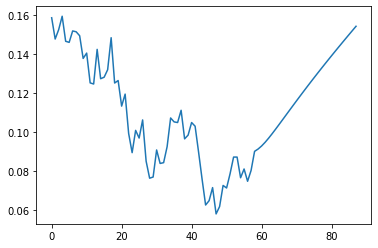

In [40]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])